# Integral Equation Model Comparisons
Purpose of this notebook is to EOS calculations for comparisons to George Petrov's Average Atom model, and Morales EOS Hydrogen paper

[https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n, P_Ideal_Fermi_Gas, E_Ideal_Fermi_Gas 


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")

ModuleNotFoundError: No module named 'mendeleev'


#### Load Morales Data

In [2]:
Morales_file = "Morales_EOS_data.dat"
Morales_df = read_csv(Morales_file, delim_whitespace=True, header=4)
Morales_EAU  = Morales_df['E[AU]']
Morales_PGPa = Morales_df['P[GPa]']
Morales_TK   = Morales_df['T[K]']
Morales_PMbar =  1e-2*Morales_PGPa
Morales_TeV = Morales_TK/eV_to_K

### Set Parameters in Paper and Plot

In [4]:
name = 'Hydrogen'
Z, A = 1,1 

Te_eV_list = np.geomspace(np.min(Morales_TeV), 1000, num=15) #np.array(GP_Te_eV) # eV
Ti_eV_list = Te_eV_list
ni_cc = 5.98e23
ni_AU = ni_cc/cm_to_AU**3

ri_cm = rs_from_n(ni_cc)  # cm
ri_AU = ri_cm*cm_to_AU    # AU 

#### Run Ornstein-Zernike Closure

In [5]:
# Define plasma method to use
name = 'OZ - th  Pauli'
plasma_func = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})

ε = 1e-6
plasma_pair_func = lambda T_eV:[plasma_func(T_eV), plasma_func(T_eV*(1-ε))]

# Helpful unit functions
P_hnc_to_AU   = lambda P_hnc: (P_hnc/ri_AU**3) 
P_hnc_to_bar  = lambda P_hnc: P_hnc_to_AU(P_hnc) *  AU_to_bar 
P_hnc_to_Mbar = lambda P_hnc: 1e-6*P_hnc_to_bar(P_hnc)
P_hnc_to_GPa  = lambda P_hnc: P_hnc_to_bar(P_hnc) * 1e5 / 1e9 
E_hnc_to_eV   = lambda E_hnc: E_hnc/plasma.hnc.rho[0] * AU_to_eV

# Create new thermodynamic variable generator
def excess_energy_density_matrix(plasma, d_βu ): # Defining   d_βu = dβ_c u/dβ = -T^2 d β_c u/dT
    g_matrix = plasma.hnc.h_r_matrix+1
    rho_matrix = plasma.hnc.rho[:,np.newaxis] * plasma.hnc.rho[np.newaxis,:]
    r = plasma.hnc.r_array[np.newaxis,np.newaxis,:]
    dr = plasma.hnc.del_r
    
    u_ex_matrix = np.sum(2*π*rho_matrix[:,:,np.newaxis]*d_βu*g_matrix*r**2*dr,axis=2)
    return u_ex_matrix

def ideal_energy_density_matrix(plasma, d_β):
    u_i_id   = 3/2 * plasma.hnc.rho[0] * plasma.qsp.Ti
    u_e_c_id = 3/2 * plasma.hnc.rho[1] * plasma.qsp.Te_c
    u_e_id   = u_e_c_id * ( d_β )#  + 0*mass) # IGNORING MASS RUNNING FOR NOW
    return np.diag([u_i_id, u_e_id ])

def chemical_potential 

def get_U_matrices(plasma_pair):
    plasma, plasma_ε = plasma_pair
    plasma.run_hnc()
    plasma_ε.run_hnc(c_s_k_guess = plasma.hnc.c_s_k_matrix.copy())
    dT_AU = plasma.qsp.Ti - plasma_ε.qsp.Ti
    T_AU = plasma.qsp.Ti
    
    # Now we need   d_βu = dβ_c u/dβ = -T^2 d β_c u/dT
    d_βu_AU = -T_AU**2*(plasma.hnc.βu_r_matrix - plasma_ε.hnc.βu_r_matrix)/dT_AU
    d_β  = -T_AU**2*( 1/plasma.qsp.Te_c - 1/plasma_ε.qsp.Te_c)/dT_AU

    # Get energies
    U_ex = excess_energy_density_matrix(plasma, d_βu_AU )
    U_id = ideal_energy_density_matrix(plasma, d_β)
    
    # Convert units
    E_id_AU, E_ex_AU, E_AU = U_id/plasma.hnc.rho[0], U_ex/plasma.hnc.rho[0], (U_id + U_ex)/plasma.hnc.rho[0]
    E_id_eV, E_ex_eV, E_eV = E_id_AU*AU_to_eV, E_ex_AU*AU_to_eV, E_AU*AU_to_eV
    return E_id_eV, E_ex_eV, E_eV

def get_U(plasma_pair):
    U_id_matrix, U_ex_matrix, U_matrix = get_U_matrices(plasma_pair)
    return np.sum(U_id_matrix), np.sum(U_ex_matrix), np.sum(U_matrix)

get_U_matrices(plasma_pair_func(1e4))

Te_in_eV: 10000.000
Ti_in_eV: 10000.000


/home/zach/plasma/hnc/hnc/PIE.py:186: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))
/home/zach/plasma/hnc/hnc/PIE.py:187: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]
/home/zach/plasma/hnc/hnc/PIE.py:187: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]


Te_in_eV: 9999.990
Ti_in_eV: 9999.990
0: Initial condition Total Error: 2.494e-03
Exiting status 0, reverting to best index so far: 18
Final iter:19, Total Error: 9.514e-09
0: Initial condition Total Error: 1.173e-08
Exiting status 0, reverting to best index so far: 1
Final iter:2, Total Error: 5.865e-09


(array([[15000.        ,     0.        ],
        [    0.        , 15000.01499995]]),
 array([[ 5871.88054915, -5872.90472622],
        [-5872.90472622,  5872.14109922]]),
 array([[20871.88054915, -5872.90472622],
        [-5872.90472622, 20872.15609916]]))

### Compute all plasma models for list of densities

In [6]:
EOS_list = []

for T_eV in Te_eV_list:
    plasma_pair = plasma_pair_func(T_eV)
    E_id_eV, E_ex_eV, E_eV = get_U(plasma_pair)
    EOS_list.append( [E_id_eV, E_ex_eV, E_eV] )
    
EOS_list = np.array(EOS_list)

Te_in_eV: 0.172
Ti_in_eV: 0.172


/home/zach/plasma/hnc/hnc/PIE.py:193: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 1.212e+02


/home/zach/plasma/hnc/hnc/hnc.py:332: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)
/home/zach/plasma/hnc/hnc/hnc.py:434: RuntimeWarning: overflow encountered in exp
  tot_eqn =  1 + h_r_matrix  - np.exp(-self.βu_s_r_matrix + h_r_matrix - c_s_r_matrix )
/home/zach/plasma/hnc/hnc/hnc.py:514: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)
/home/zach/plasma/hnc/hnc/hnc.py:630: RuntimeWarning: overflow encountered in exp
  hnc_err = np.linalg.norm(- 1 - self.h_r_matrix   + np.exp( -self.βu_r_matrix + self.h_r_matrix - self.c_r_matrix ))/np.sqrt(self.N_bins*self.N_species**2)
/home/zach/plasma/hnc/hnc/hnc.py:638: RuntimeWarning: invalid value encountered in subtract
  Δ_err = np.array(self.tot_err_list[-iters_to_check:-2]) - np.array(self.tot_err_list[-iters_to_check + 1:-1])


QUIT: Total error infinite.
Exiting status 1, reverting to best index so far: 0
Final iter:21, Total Error: 1.212e+02
QUIT: Picard Err too high. Newton assumed not to converge. Try better initial condition or smaller α.
0: Initial condition Total Error: 1.212e+02
QUIT: Total error infinite.
Exiting status 1, reverting to best index so far: 0
Final iter:21, Total Error: 1.212e+02
QUIT: Picard Err too high. Newton assumed not to converge. Try better initial condition or smaller α.
Te_in_eV: 0.320
Ti_in_eV: 0.320
Te_in_eV: 0.320
Ti_in_eV: 0.320
0: Initial condition Total Error: 8.970e+00
Exiting status 0, reverting to best index so far: 471
Final iter:472, Total Error: 9.924e-09
0: Initial condition Total Error: 1.659e-05
Exiting status 0, reverting to best index so far: 95
Final iter:96, Total Error: 9.855e-09
Te_in_eV: 0.594
Ti_in_eV: 0.594
Te_in_eV: 0.594
Ti_in_eV: 0.594
0: Initial condition Total Error: 4.661e+00
Exiting status 0, reverting to best index so far: 281
Final iter:282, To

### Energy per Atom

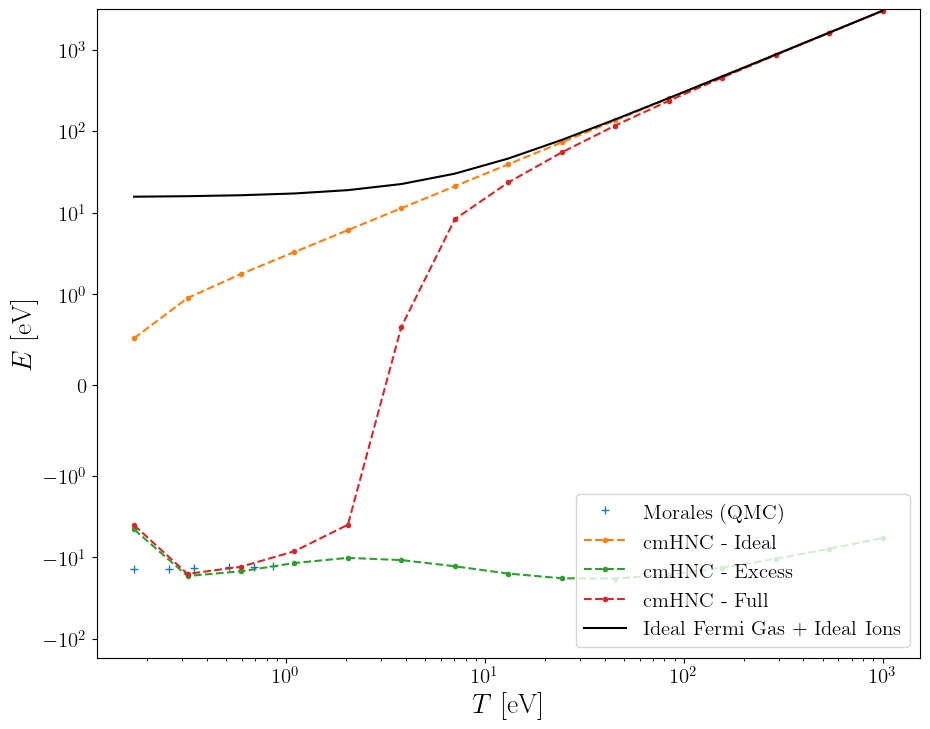

In [7]:
from hnc.hnc.misc import Fermi_Energy

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_EAU*AU_to_eV, '+', label='Morales (QMC)')

# Plot Energy
axs[0].plot(Te_eV_list, EOS_list[:,0],'--.', label="cmHNC - Ideal")
axs[0].plot(Te_eV_list, EOS_list[:,1],'--.', label="cmHNC - Excess")
axs[0].plot(Te_eV_list, EOS_list[:,2],'--.', label="cmHNC - Full")

# Plot Fermi Pressure
E_ideal_eV_func = lambda Te_eV, Ti_eV: E_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_eV + 3/2*Ti_eV
E_ideal_eV_func = np.vectorize(E_ideal_eV_func)

Ee_ideal_eV = [E_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_eV for Te_eV in Te_eV_list]
Ei_ideal_eV = 3/2*Ti_eV_list

# axs[0].plot(Te_eV_list, Ee_ideal_eV,'k--', label="Ideal Fermi Gas"  ) 
# axs[0].plot(Te_eV_list, 3/5*Fermi_Energy(ni_AU)*np.ones_like(Te_eV_list)*AU_to_eV,'k--.', label="Degnerate Fermi Gas"  ) 
# axs[0].plot(Te_eV_list, Ei_ideal_eV,'k-.', label="Ideal Gas"  ) 
axs[0].plot(Te_eV_list, Ee_ideal_eV + Ei_ideal_eV,'k-', label="Ideal Fermi Gas + Ideal Ions"  ) 

for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$E$ [eV]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()

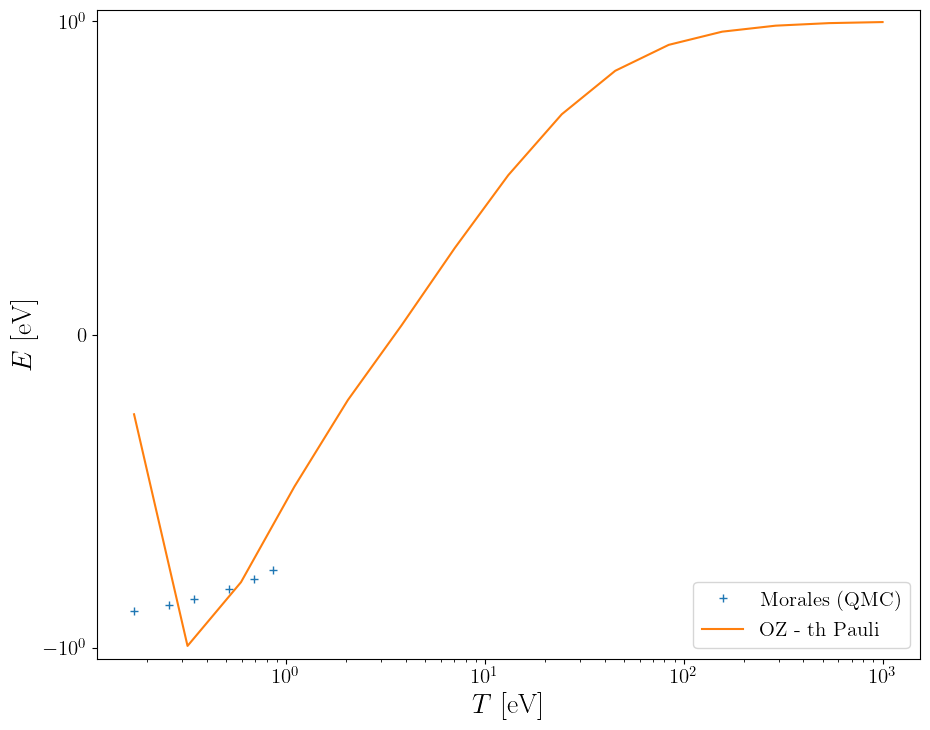

In [8]:
from hnc.hnc.misc import Fermi_Energy

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_EAU*AU_to_eV/E_ideal_eV_func(Morales_TeV,Morales_TeV), '+', label='Morales (QMC)')

# Plot Energy
axs[0].plot(Te_eV_list, EOS_list[:,2]/E_ideal_eV_func(Te_eV_list,Te_eV_list), label=name)

for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$E$ [eV]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()

# Getting Energy Right at Low T

In [9]:
plasma_5 = lambda T_eV: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':100,'N_bins':20000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})

plasma_new = plasma_5(2000 / eV_to_K)
plasma_new.run_hnc()


Te_in_eV: 0.172
Ti_in_eV: 0.172


/home/zach/plasma/hnc/hnc/PIE.py:186: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))
/home/zach/plasma/hnc/hnc/PIE.py:193: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


0: Initial condition Total Error: 6.018e+01


/home/zach/plasma/hnc/hnc/hnc.py:332: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)
/home/zach/plasma/hnc/hnc/hnc.py:434: RuntimeWarning: overflow encountered in exp
  tot_eqn =  1 + h_r_matrix  - np.exp(-self.βu_s_r_matrix + h_r_matrix - c_s_r_matrix )
/home/zach/plasma/hnc/hnc/hnc.py:514: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)
/home/zach/plasma/hnc/hnc/hnc.py:630: RuntimeWarning: overflow encountered in exp
  hnc_err = np.linalg.norm(- 1 - self.h_r_matrix   + np.exp( -self.βu_r_matrix + self.h_r_matrix - self.c_r_matrix ))/np.sqrt(self.N_bins*self.N_species**2)
/home/zach/plasma/hnc/hnc/hnc.py:638: RuntimeWarning: invalid value encountered in subtract
  Δ_err = np.array(self.tot_err_list[-iters_to_check:-2]) - np.array(self.tot_err_list[-iters_to_check + 1:-1])


QUIT: Total error infinite.
Exiting status 1, reverting to best index so far: 0
Final iter:21, Total Error: 6.018e+01
QUIT: Picard Err too high. Newton assumed not to converge. Try better initial condition or smaller α.


In [ ]:
plasma_new.hnc.total_energy_density()

In [ ]:
E_hnc_to_eV( plasma_new.hnc.total_energy_density()) 

In [ ]:
plasma_new.hnc.excess_energy_density_matrix(), np.sum(plasma_new.hnc.excess_energy_density_matrix()), plasma_new.hnc.ideal_energy_density()

In [ ]:
def plot_g_all_species(plasma, data_to_compare=None, data_names=None, gmax=None):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
    fig.suptitle("Radial Distribution Function for all Species", fontsize=20, y=1)

    for i in range(plasma.N_species):
        for j in range(plasma.N_species):
            ax.plot(plasma.r_array, plasma.h_r_matrix[i,j]+1,'--.', label=plasma.name_matrix[i][j] + r", $\Gamma_{{ {0},{1} }}$ = {2:.2f}".format(i,j,plasma.Gamma[i][j]) )

    if data_to_compare:
        for file_name, label in zip(data_to_compare, data_names):
            r_datas, g_datas = np.array(read_csv(file_name, delimiter=',', header=1)).T
            ax.plot(r_datas, g_datas, '-', label=label)
            ax.legend(fontsize=15)

    if gmax:
        ax.set_ylim(0, gmax)

    ax.tick_params(labelsize=20)
    ax.set_xlabel(r"$r/r_s$", fontsize=20)
    ax.set_xlim(plasma.del_r, 10)
    ax.set_ylabel(r"$g(r/r_s)$", fontsize=20)
    ax.set_ylim(0, 5)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=20, loc = 'upper left')

    ax.set_xscale('log')
    
    # plt.tight_layout()
    plt.show()

In [ ]:
plot_g_all_species(plasma_new.hnc)

In [ ]:
def plot_gr2_all_species(plasma, data_to_compare=None, data_names=None, gmax=None):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
    fig.suptitle("Radial Distribution Function for all Species", fontsize=20, y=1)

    for i in range(plasma.N_species):
        for j in range(plasma.N_species):
            ax.plot(plasma.r_array, (plasma.h_r_matrix[i,j]+1)*plasma.r_array**2,'--.', label=plasma.name_matrix[i][j] + r", $\Gamma_{{ {0},{1} }}$ = {2:.2f}".format(i,j,plasma.Gamma[i][j]) )

    if data_to_compare:
        for file_name, label in zip(data_to_compare, data_names):
            r_datas, g_datas = np.array(read_csv(file_name, delimiter=',', header=1)).T
            ax.plot(r_datas, g_datas, '-', label=label)
            ax.legend(fontsize=15)

    if gmax:
        ax.set_ylim(0, gmax)

    ax.tick_params(labelsize=20)
    ax.set_xlabel(r"$r/r_s$", fontsize=20)
    # ax.set_xlim(plasma.del_r, 10)
    ax.set_ylabel(r"$g(r/r_s)$", fontsize=20)
    # ax.set_ylim(0, 5)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=20, loc = 'upper left')

    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # plt.tight_layout()
    plt.show()
plot_gr2_all_species(plasma_new.hnc)

In [ ]:
from scipy.integrate import simpson
def excess_energy_density_matrix(hnc):

    g_matrix = hnc.h_r_matrix+1
    rho_matrix = hnc.rho[:,np.newaxis]*hnc.rho[np.newaxis,:]
    r = hnc.r_array[np.newaxis,np.newaxis,:]
    dr = hnc.del_r
    
    u_matrix = hnc.βu_r_matrix*hnc.Temp_matrix[:,:,np.newaxis]
    u_matrix = np.array([[1/hnc.r_array,-1/hnc.r_array],[-1/hnc.r_array,1/hnc.r_array]])
    print(u_matrix.shape)
    
    # u_ex_matrix = np.sum(2*π*rho_matrix[:,:,np.newaxis]*u_matrix*g_matrix*r**2*dr,axis=2)
    u_ex_matrix = simpson(2*π*rho_matrix[:,:,np.newaxis]*u_matrix*(g_matrix)*r**2, r , axis=2)

    return u_ex_matrix
E_ex_matrix = excess_energy_density_matrix(plasma_new.hnc) 
E_ex_matrix, np.sum(E_ex_matrix), E_hnc_to_eV(np.sum(E_ex_matrix))